## Purpose

The purpose of this file is to create a model which will predict smoke estimates for Pahrump over the next 25 years (2024-2049). Of note, our smoke estimates stop at 2020, consistent with the underlying data used to create them (see README for more), so our model will be estimating almost 50 years beyond the end of our data.

We begin by loading basic python libraries.

In [68]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#Getting smoke estimates
smoke_est = pd.read_csv('../clean_data/annual_smoke_estimate.csv')
#smoke_est.head()

Let's start by visualizing our data. This will give us a sense of smoke over time and allow us to better estimate what model(s) would be appropriate to use.

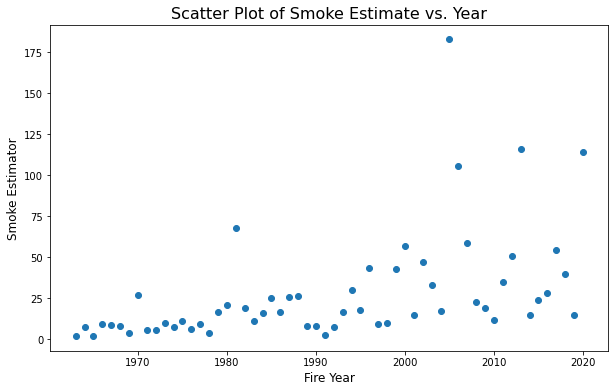

In [69]:
#Graphing the two columns to see the relationship
x = smoke_est['Fire_Year']
y = smoke_est['Annual_Smoke_Estimate']

plt.figure(figsize=(10, 6))
plt.scatter(x, y)
plt.title("Scatter Plot of Smoke Estimate vs. Year", size=16)
plt.xlabel('Fire Year', size=12)
plt.ylabel('Smoke Estimator', size=12)
plt.show()

From the above image we can see that the relationship between year and smoke is linear or perhaps exponential. We will start by using a linear regression model and will validate its goodness of fit using the correlation coefficient (r). 

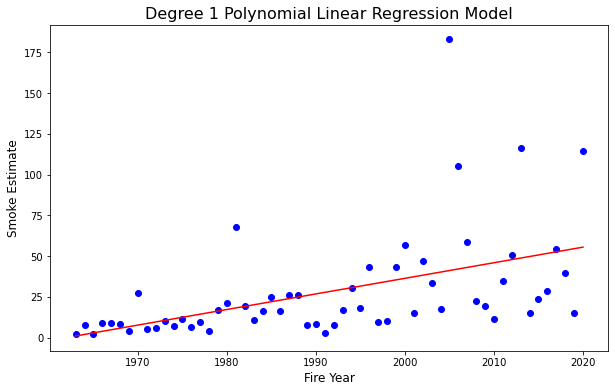

The r-squared value for the linear regression is 0.2385907472073704.


In [70]:
#Graphing the two columns to see the relationship
X = np.array(x)
Y = np.array(y)

# Fit a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X.reshape(-1, 1), Y)

#Get the predicted y
y_pred = lin_reg.predict(X.reshape(-1, 1))

#Making the graph
plt.figure(figsize=(10, 6))
plt.title("Degree 1 Polynomial Linear Regression Model", size=16)
plt.scatter(X, Y, marker= 'o', color = 'blue')
plt.plot(X, y_pred, c="red")
plt.xlabel('Fire Year', size=12)
plt.ylabel('Smoke Estimate', size=12)
plt.show()

print("The r-squared value for the linear regression is {0}.".format(lin_reg.score(X.reshape(-1, 1), Y)))

It would appear that our correlation coefficient is 0.24, which is a relatively low amount of variance explained. Typically when evaluating the appropriateness of a linear regression we would consider if there is a linear relationship, multivariate normality (normally distributed errors), little to no collinearity (correlated variables), no auto-correlation (repeating trends over time), and homoscedacity (equal variance of errors). We know that we have satisfied collinearity and auto-correlation, and may have satisfied a linear relationship. However, we should example if our data follows a normal distribution and has equal variance across datapoints. We will use code from ChatGPT to create the residuals vs. fitted values plot and a Q-Q plot given we typically code these in R. 

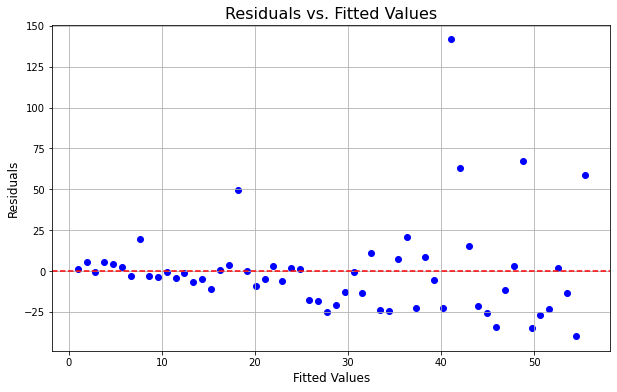

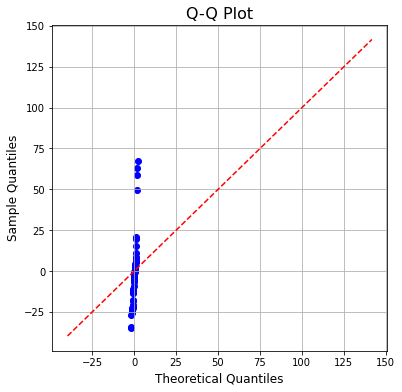

In [71]:
#This cell of code code largely from ChatGPT

#Examining the homoscedacity 
#Resetting x and y to numpy arrays
X = np.array(x)
Y = np.array(y)

# Fit a linear regression model
reg = LinearRegression()
reg.fit(X.reshape(-1, 1), Y)

#Calculate residuals
y_pred = reg.predict(X.reshape(-1, 1))
residuals = Y - y_pred

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, marker='o', color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values', size=12)
plt.ylabel('Residuals', size=12)
plt.title('Residuals vs. Fitted Values', size=16)
plt.grid(True)

# Display the plot
plt.show()

#Examining multivariate normality
# Sort the data in ascending order
data_sorted = np.sort(residuals)

# Generate quantiles for the theoretical normal distribution
theoretical_quantiles = stats.norm.ppf(np.linspace(0, 1, len(data_sorted)))

# Create the Q-Q plot
plt.figure(figsize=(6, 6))
plt.scatter(theoretical_quantiles, data_sorted, color='blue')
plt.plot([np.min(data_sorted), np.max(data_sorted)], [np.min(data_sorted), np.max(data_sorted)], color='red', linestyle='--')
plt.xlabel('Theoretical Quantiles', size=12)
plt.ylabel('Sample Quantiles', size=12)
plt.title('Q-Q Plot', size=16)
plt.grid(True)

plt.show()

As we can see from the Residuals vs. Fitted values, we may have issues with our homoscedacity (inconsistent variance in our residuals). Additionally, our Q-Q plot does not show good adherence to the 45 degree line, indicating that multivariate normality cannot be assumed. We will attempt to model the data using a polynomial linear regression to see if we can get a better fit as measured by the r-squared value.

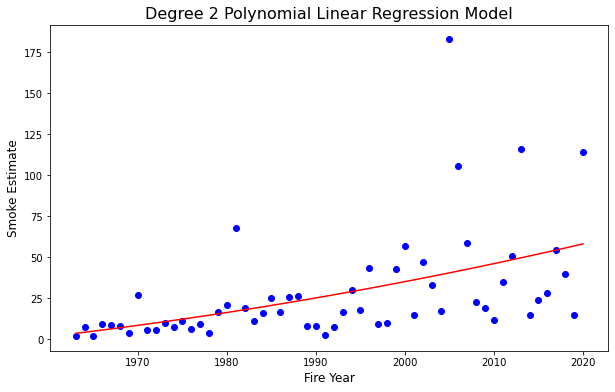

The r-squared value for the polynomial linear regression is 0.24018340117017967.


In [72]:
#Degree 2 polynomial linear regression
poly = PolynomialFeatures(degree=2, include_bias=False)

#Reshaping X
poly_features = poly.fit_transform(X.reshape(-1, 1))

#Creating linear regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, Y)
y_predicted = poly_reg_model.predict(poly_features)

#Graphing poly deg-2 linear regression model
plt.figure(figsize=(10, 6))
plt.title("Degree 2 Polynomial Linear Regression Model", size=16)
plt.scatter(X, Y, marker= 'o', color = 'blue')
plt.plot(X, y_predicted, c="red")
plt.xlabel('Fire Year', size=12)
plt.ylabel('Smoke Estimate', size=12)
plt.show()

#Print the r squared
print("The r-squared value for the polynomial linear regression is {0}.".format(poly_reg_model.score(poly_features, Y)))

We can see that the r-squared value for our degree 2 linear regression model is not much better than our simple linear regression. We do not believe the fit would be improved by increasing the degree thus we will "regress to regression" for our final model. We create the following predictions for years 1963-2049 using our linear model below.

In [80]:
#Reformatting the independent and dependent variables
X = np.array(x)
Y = np.array(y)

# Fit a linear regression model to the data
lin_reg = LinearRegression()
lin_reg.fit(X.reshape(-1, 1), Y)

#Get the predicted y (smoke)
fire_years = []
for value in range(1963, 2050):
    fire_years.append(value)
Fire_Years = np.array(fire_years)
predicted_smoke = reg.predict(Fire_Years.reshape(-1, 1))

#Create df with input and predicted values
smoke_pred_df = pd.DataFrame({"Fire Year":fire_years, 'Predicted Smoke Estimates': predicted_smoke})

It's important to recognize that there is uncertianty in our smoke predictions, captured by confidence intervals (where we have data e.g., pre-2020) and prediction intervals (where we don't have data e.g., post-2020). We will begin by calculating confidence intervals for all smoke estimates before or during 2020. We will use 95% confidence intervals, meaning the actual value of the estimator is within the interval 95% of the time. However, given we have heterscedacity (non-uniform residuals) vs fitted values, we know that this confidence interval may be over or under-conservative.  

In [81]:
#t-statistic
n = len(Y)
alpha = 0.05
t_stat = stats.t.ppf(1-alpha/2, df=n-2)

#standard error
delta = Y - predicted_smoke[:n]
delta_squared = delta**2
sum_delt_squared = delta_squared.sum()
st_error = sum_delt_squared/(n-2)

#x error denom
delta_x = X - X.mean()
delta_x_sq = delta_x**2
sum_delt_x_sq = delta_x_sq.sum()

#Iterate through X values to create smoke estimate confidence intervals
interval = []
for year in smoke_pred_df['Fire Year']:
    paren = (1/n)+((year-X.mean())**2)/sum_delt_x_sq
    under_root = st_error * paren
    interval.append(t_stat*math.sqrt(under_root))

#Adding upper and lower prediction bounds to the data
smoke_pred_df['prediction_values'] = interval
smoke_pred_df['lower_confidence_bound'] = smoke_pred_df['Predicted Smoke Estimates'] - smoke_pred_df['prediction_values']
smoke_pred_df['upper_confidence_bound'] = smoke_pred_df['Predicted Smoke Estimates'] + smoke_pred_df['prediction_values']

#Removing the prediction_values b/c no longer needed
smoke_pred_df = smoke_pred_df.drop(['prediction_values'], axis = 1)

#Removing the upper and lower bounds on predictions where the year is <= 2020
smoke_pred_df.loc[smoke_pred_df['Fire Year']> 2020, 'lower_confidence_bound'] = None
smoke_pred_df.loc[smoke_pred_df['Fire Year']> 2020, 'upper_confidence_bound'] = None
#smoke_pred_df[53:63]

Now we will calculate the prediction intervals for all smoke estimations after 2020. Because we do not have supporting data, the intervals will be wider. Again, we will use a 95% interval, meaning that the predicted smoke estimator is within the interval 95% of the time. However, given we have heterscedacity (non-uniform residuals) vs fitted values, we know that this prediction interval may be over or under-conservative. 

In [82]:
#Iterate through X values to create smoke estimate prediction intervals
interval = []
for year in smoke_pred_df['Fire Year']:
    paren = 1+(1/n)+((year-X.mean())**2)/sum_delt_x_sq
    under_root = st_error * paren
    interval.append(t_stat*math.sqrt(under_root))

#Adding upper and lower prediction bounds to the data
smoke_pred_df['prediction_values'] = interval
smoke_pred_df['lower_prediction_bound'] = smoke_pred_df['Predicted Smoke Estimates'] - smoke_pred_df['prediction_values']
smoke_pred_df['upper_prediction_bound'] = smoke_pred_df['Predicted Smoke Estimates'] + smoke_pred_df['prediction_values']

#Removing the prediction_values b/c no longer needed
smoke_pred_df = smoke_pred_df.drop(['prediction_values'], axis = 1)

#Removing the upper and lower bounds on predictions where the year is <= 2020
smoke_pred_df.loc[smoke_pred_df['Fire Year']<= 2020, 'lower_prediction_bound'] = None
smoke_pred_df.loc[smoke_pred_df['Fire Year']<= 2020, 'upper_prediction_bound'] = None
#smoke_pred_df[53:63]

Finally, we will consolidate the interval columns into a single "upper_estimate_bound" column and a single "lower_estimate_bound" column. We will also include the actual smoke_estimates for graphing in the next cell.

In [83]:
#Conditionally combining the lower and upper estimate bounds
smoke_pred_df['Lower Estimate Bound'] = np.where(smoke_pred_df['lower_confidence_bound'].isna(),
                                                 smoke_pred_df['lower_prediction_bound'],
                                                 smoke_pred_df['lower_confidence_bound'])
smoke_pred_df['Upper Estimate Bound'] = np.where(smoke_pred_df['upper_confidence_bound'].isna(),
                                                 smoke_pred_df['upper_prediction_bound'],
                                                 smoke_pred_df['upper_confidence_bound'])


#Remove the individual confidence and prediction columns
smoke_pred_df = smoke_pred_df.drop(['lower_confidence_bound', 'upper_confidence_bound',
                    'lower_prediction_bound', 'upper_prediction_bound'], axis = 1)

#Adding in the calculated smoke estimates
na_list = []
for diff in range(len(Fire_Years)-len(y)):
    na_list.append(None)
calc_smoke_est = list(y) + na_list
smoke_pred_df['Calculated Smoke Estimates'] = calc_smoke_est

#Save the dataframe
smoke_pred_df.to_csv('../clean_data/2049_smoke_estimates.csv', index = None)

To help visualize the estimates vs actual smoke calculations we will create the below graph.

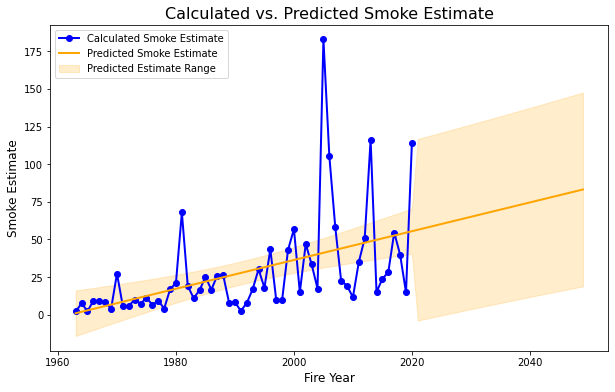

In [91]:
#Creating variables
year = smoke_pred_df['Fire Year']
calc_smoke = smoke_pred_df['Calculated Smoke Estimates']
pred_smoke = smoke_pred_df['Predicted Smoke Estimates']
lower_smoke = smoke_pred_df['Lower Estimate Bound']
upper_smoke = smoke_pred_df['Upper Estimate Bound']

#Building graph
plt.figure(figsize=(10, 6))
plt.title("Calculated vs. Predicted Smoke Estimate", size=16)
plt.xlabel('Fire Year', size=12)
plt.ylabel('Smoke Estimate', size=12)
plt.plot(year, calc_smoke, c="blue", marker='o', linestyle='solid',
     linewidth=2, markersize=6)
plt.plot(year, pred_smoke, c="orange", linestyle='solid', linewidth=2)
#plt.plot(year, lower_smoke, c="orange", linestyle='solid', linewidth=2)
#plt.plot(year, upper_smoke, c="orange", linestyle='solid', linewidth=2)
plt.fill_between(year, lower_smoke, upper_smoke, alpha=0.2, color = 'orange')
plt.legend(['Calculated Smoke Estimate','Predicted Smoke Estimate',
            'Predicted Estimate Range'], loc ="upper left")
plt.show()